# Import Libraries

In [1]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import warnings
warnings.filterwarnings('ignore')

# data structures:
import numpy as np
import pandas as pd
from collections import Counter

# visuals:
import matplotlib.pyplot as plt
import seaborn as sns

# data transformations:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import chi2

# model evaluation:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# models:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Import Tensorflow libraries
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.optimizers import adam
from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


# Read in the data from file

In [2]:
# Import dataset
dataset = pd.read_csv('../data/cancer.csv')
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Introduction to the data

In [3]:
dataset.shape

(569, 32)

In [4]:
pd.Series(dataset.columns.values)[~pd.Series(dataset.columns.values).isin(['id'])].values

array(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Class ratios - imbalanced class set

In [6]:
class_ratio = pd.DataFrame(dict(Counter(dataset['diagnosis'])),index=[0],columns=['M','B'])
print('Ratio M: {}'.format(class_ratio['M'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))
print('Ratio B: {}'.format(class_ratio['B'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))

Ratio M: 37.258347978910365
Ratio B: 62.741652021089635


# Split data into train and test

In [7]:
# Preprocessing 
dataset.drop('id',axis=1, inplace=True)

# Split into features and targets
y = dataset['diagnosis']

# Create training set and test set
X_train, X_test = train_test_split(dataset, test_size=0.20, shuffle=True, stratify=y)

Ratios of the classes in train and test are still representative to that of the original data set

In [8]:
class_ratio = pd.DataFrame(dict(Counter(X_train['diagnosis'])),index=[0],columns=['M','B'])
print('Ratio M: {}'.format(class_ratio['M'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))
print('Ratio B: {}'.format(class_ratio['B'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))

Ratio M: 37.362637362637365
Ratio B: 62.637362637362635


In [9]:
class_ratio = pd.DataFrame(dict(Counter(X_test['diagnosis'])),index=[0],columns=['M','B'])
print('Ratio M: {}'.format(class_ratio['M'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))
print('Ratio B: {}'.format(class_ratio['B'].values[0]/(class_ratio['M'].values[0] + class_ratio['B'].values[0])*100))

Ratio M: 36.84210526315789
Ratio B: 63.1578947368421


# Exploring the data

## Gathering descriptive statistics per class

In [10]:
descriptive_stats_M = np.transpose(X_train[X_train['diagnosis']=='M'].describe())
descriptive_stats_B = np.transpose(X_train[X_train['diagnosis']=='B'].describe())

Computing the IQR range for using as a measure to detect outliers within each class

In [11]:
Q1 = descriptive_stats_M['25%']
Q3 = descriptive_stats_M['75%']
descriptive_stats_M['IQR'] = Q3 - Q1
IQR_lookup_table_M = dict(zip(descriptive_stats_M.index.values,descriptive_stats_M['IQR']))
Q1_lookup_table_M = dict(zip(descriptive_stats_M.index.values,descriptive_stats_M['25%']))
Q3_lookup_table_M = dict(zip(descriptive_stats_M.index.values,descriptive_stats_M['75%']))

Q1 = descriptive_stats_B['25%']
Q3 = descriptive_stats_B['75%']
descriptive_stats_B['IQR'] = Q3 - Q1
IQR_lookup_table_B = dict(zip(descriptive_stats_B.index.values,descriptive_stats_B['IQR']))
Q1_lookup_table_B = dict(zip(descriptive_stats_B.index.values,descriptive_stats_B['25%']))
Q3_lookup_table_B = dict(zip(descriptive_stats_B.index.values,descriptive_stats_B['75%']))

## Buidling outlier detection function

In [12]:
def outlier_detection(data,feature):
    return_series = list()
    for row in data.loc[:,[feature,'diagnosis']].iterrows():
        if row[1]['diagnosis'] == 'M':
            if (row[1][feature] < Q1_lookup_table_M.get(feature) - 1.5*IQR_lookup_table_M.get(feature)) or (row[1][feature] > Q3_lookup_table_M.get(feature) + 1.5*IQR_lookup_table_M.get(feature)):
                return_series.append(0)
            else:
                return_series.append(1)
        if row[1]['diagnosis'] == 'B':
            if (row[1][feature] < Q1_lookup_table_B.get(feature) - 1.5*IQR_lookup_table_B.get(feature)) or (row[1][feature] > Q3_lookup_table_B.get(feature) + 1.5*IQR_lookup_table_B.get(feature)):
                return_series.append(0)
            else:
                return_series.append(1)
    return pd.Series(return_series)            

In [13]:
def plot_boxplots(X,y,list_of_features):
    plt.figure(figsize=(10,5))
    i = 0
    for feature in list_of_features:   
            loc = '24'+str(i)
            plt.subplot(loc)
            sns.boxplot(x=y,y=X[feature])
            i += 1    
    plt.tight_layout()        
    plt.show()

Below box plots show that some of the features do separate the class label well, but there is also somewhat noise in the data (outliers)

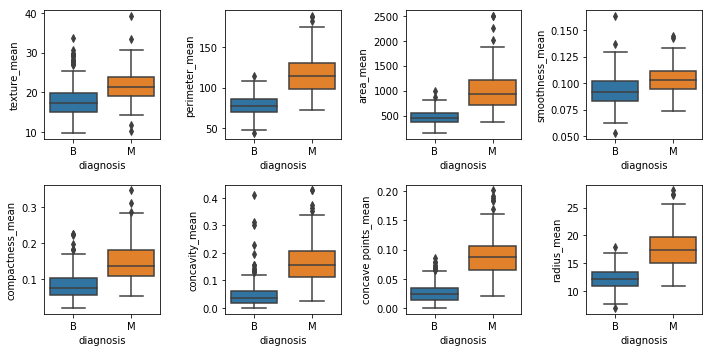

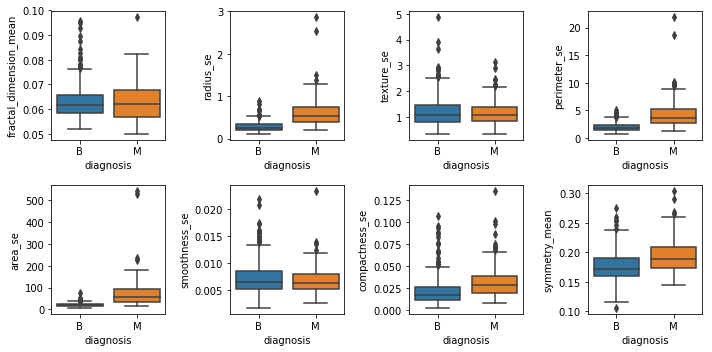

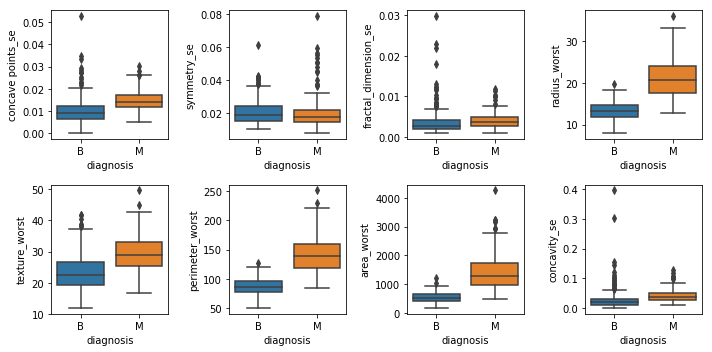

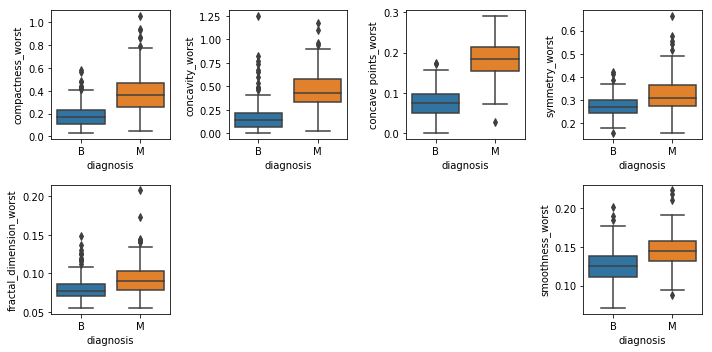

In [14]:
i = 0
j = 8
while i < X_train.shape[1]:
    plot_boxplots(X=X_train.loc[:,pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])]],y=X_train['diagnosis'],list_of_features=list(pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])])[i:j])
    i = j
    j += 8

## Creating new features with outliers removed

In [15]:
outlier_df_train = pd.DataFrame({feature : list(outlier_detection(data=X_train,feature=feature)) for feature in list(pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])])},index=X_train.index.values)

In [16]:
outlier_df_test = pd.DataFrame({feature : list(outlier_detection(data=X_test,feature=feature)) for feature in list(pd.Series(X_test.columns.values)[~pd.Series(X_test.columns.values).isin(['diagnosis'])])},index=X_test.index.values)

In [17]:
for feature in list(pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])]):
    X_train[feature+'_outlier_removed'] = X_train[feature]*outlier_df_train[feature]

In [18]:
for feature in list(pd.Series(X_test.columns.values)[~pd.Series(X_test.columns.values).isin(['diagnosis'])]):
    X_test[feature+'_outlier_removed'] = X_test[feature]*outlier_df_test[feature]

In [19]:
outlier_removed_features = [feature for feature in list(pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])]) if feature.find('_outlier') != -1]

In [20]:
total_obs_M = X_train[X_train['diagnosis']=='M'].shape[0]
total_obs_excl_outliers_M = list()
for feature in outlier_removed_features:
    total_obs_excl_outliers_M.append(total_obs_M - Counter(X_train[X_train['diagnosis']=='M'][feature])[0])

total_obs_B = X_train[X_train['diagnosis']=='B'].shape[0]
total_obs_excl_outliers_B = list()
for feature in outlier_removed_features:
    total_obs_excl_outliers_B.append(total_obs_B - Counter(X_train[X_train['diagnosis']=='B'][feature])[0])
    

In [21]:
M=np.array(np.sum(X_train[X_train['diagnosis']=='M'].loc[:,outlier_removed_features].values,axis=0)/np.array(total_obs_excl_outliers_M),dtype='float64')
B=np.array(np.sum(X_train[X_train['diagnosis']=='B'].loc[:,outlier_removed_features].values,axis=0)/np.array(total_obs_excl_outliers_B),dtype='float64')

Lookup table containing the mean value replacement values. These values are calculated after the outliers has been removed

In [22]:
mean_observed_feature_lookup = dict(zip(list(pd.Series(X_train.columns.values)[~pd.Series(X_train.columns.values).isin(['diagnosis'])]),list(zip(M,B))))
mean_observed_feature_lookup

{'radius_mean': (17.3277245508982, 12.100233215547703),
 'texture_mean': (21.447891566265056, 17.241263940520444),
 'perimeter_mean': (114.54754491017961, 77.80035335689045),
 'area_mean': (952.8692771084337, 456.32791519434625),
 'smoothness_mean': (0.10285559523809525, 0.09279145390070921),
 'compactness_mean': (0.1455788622754491, 0.07841609318996416),
 'concavity_mean': (0.15774084848484848, 0.04193394182509506),
 'concave points_mean': (0.0862273780487805, 0.025235981132075473),
 'symmetry_mean': (0.19124277108433738, 0.1738017985611511),
 'fractal_dimension_mean': (0.0627914201183432, 0.0618842750929368),
 'radius_se': (0.5733289156626507, 0.27188840579710144),
 'texture_se': (1.129866463414634, 1.1539711678832119),
 'perimeter_se': (3.9673742331288344, 1.9016576642335767),
 'area_se': (65.73126506024097, 19.732875000000003),
 'smoothness_se': (0.006482524096385543, 0.0067866851851851855),
 'compactness_se': (0.02952504347826087, 0.018388756554307117),
 'concavity_se': (0.0388984

The distribution below shows the quantity of outliers present within each feature for the training data. The image shows also that if I were to throw away these observations there would be very little data points remaining.

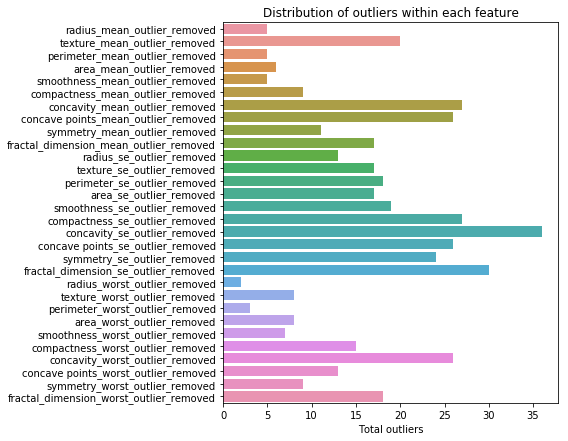

In [23]:
total_ouliers = {feature : dict(Counter(X_train[feature])).get(0.0,0) for feature in outlier_removed_features}
plt.figure(figsize=(6,7))
sns.barplot(x=list(total_ouliers.values()),y=list(total_ouliers.keys()))
plt.title('Distribution of outliers within each feature')
plt.xlabel('Total outliers')
plt.show()

In [24]:
for feature in outlier_removed_features:
    return_series=list()
    for row in X_train.loc[:,[feature,'diagnosis']].iterrows():
        if row[1]['diagnosis'] == 'M':
            if row[1][feature] == 0:
                val = mean_observed_feature_lookup.get(feature[0:feature.find('_outlier')])[0]
            else:
                val = row[1][feature]
        if row[1]['diagnosis'] == 'B':
            if row[1][feature] == 0:
                val = mean_observed_feature_lookup.get(feature[0:feature.find('_outlier')])[1]
            else:
                val = row[1][feature]
        return_series.append(val)        
    X_train[feature] = list(pd.Series(return_series))

The distribution below shows the quantity of outliers present within each feature for the test data.

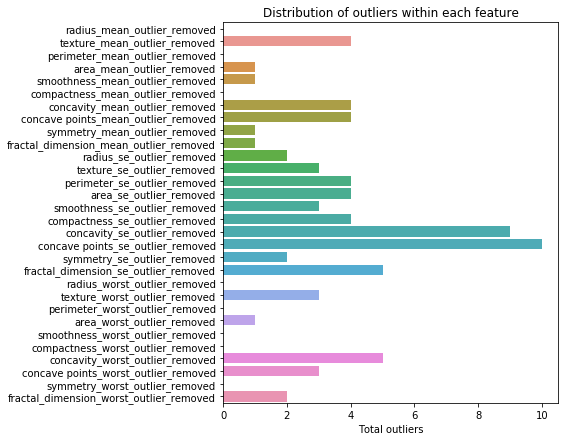

In [25]:
total_ouliers = {feature : dict(Counter(X_test[feature])).get(0.0,0) for feature in outlier_removed_features}
plt.figure(figsize=(6,7))
sns.barplot(x=list(total_ouliers.values()),y=list(total_ouliers.keys()))
plt.title('Distribution of outliers within each feature')
plt.xlabel('Total outliers')
plt.show()

In [26]:
for feature in outlier_removed_features:
    return_series=list()
    for row in X_test.loc[:,[feature,'diagnosis']].iterrows():
        if row[1]['diagnosis'] == 'M':
            if row[1][feature] == 0:
                val = mean_observed_feature_lookup.get(feature[0:feature.find('_outlier')])[0]
            else:
                val = row[1][feature]
        if row[1]['diagnosis'] == 'B':
            if row[1][feature] == 0:
                val = mean_observed_feature_lookup.get(feature[0:feature.find('_outlier')])[1]
            else:
                val = row[1][feature]
        return_series.append(val)        
    X_test[feature] = list(pd.Series(return_series))

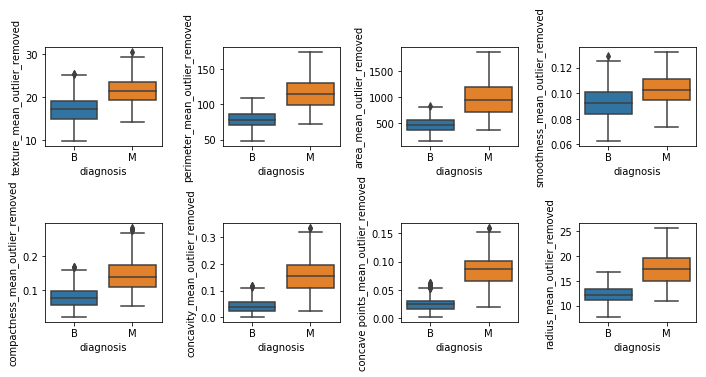

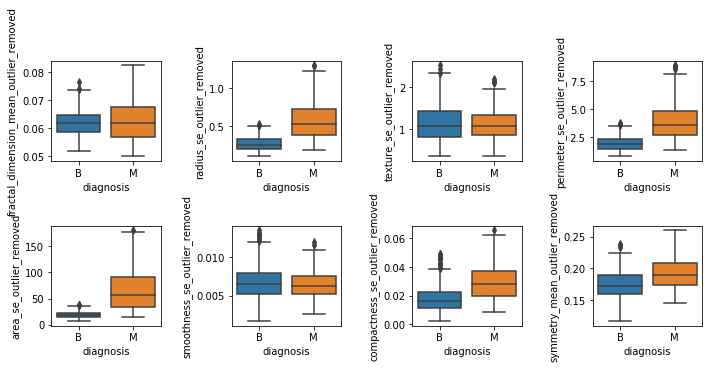

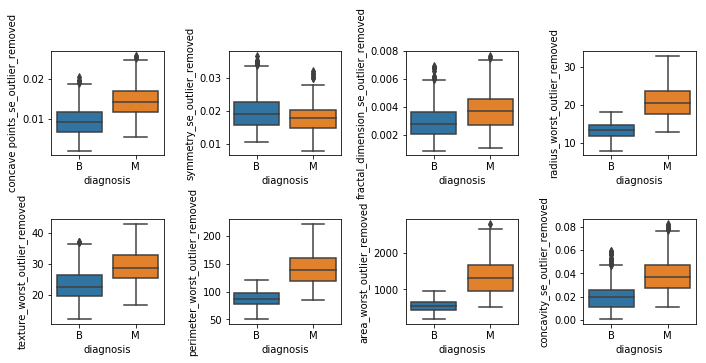

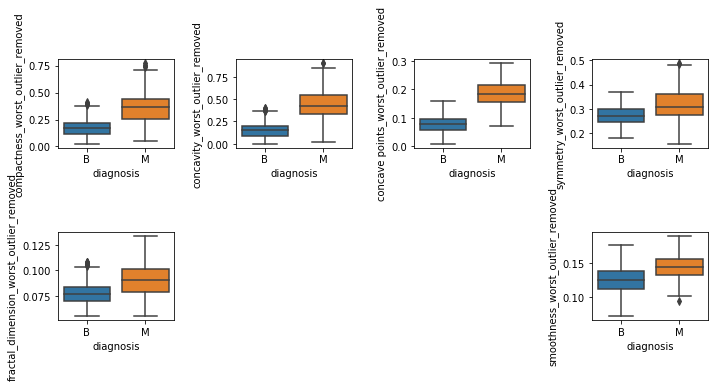

In [27]:
i = 0
j = 8
while i < len(outlier_removed_features):
    plot_boxplots(X=X_train.loc[:,outlier_removed_features],y=X_train['diagnosis'],list_of_features=outlier_removed_features[i:j])
    i = j
    j += 8  

The chi-squared test is used to determine if the distribution for a feature between the two class labels are the same or not. If the p-value is large it indicates that there is statistical evidence that the distributions are same (little separation between class labels). If the p-value is small there is efficient separation between the class labels. 

In [28]:
chi_test = {feature : chi2(X=np.reshape([X_train.loc[:,feature]],(-1,1)),y=np.reshape([X_train['diagnosis']],(-1,1)))[1][0] for feature in outlier_removed_features}

In [29]:
sorted_list = sorted(list(zip(list(chi_test.values()),list(chi_test.keys()))),reverse=False)
p_values = [i[0] for i in sorted_list]
features = [i[1] for i in sorted_list]

The image below can be used in conjunction with the box plots above. The features with larger p-values will have more overlap between the two box plots for each of the target labels. The features to the top (small p-values) will have very little overlap between the two box plots for each of the target labels.

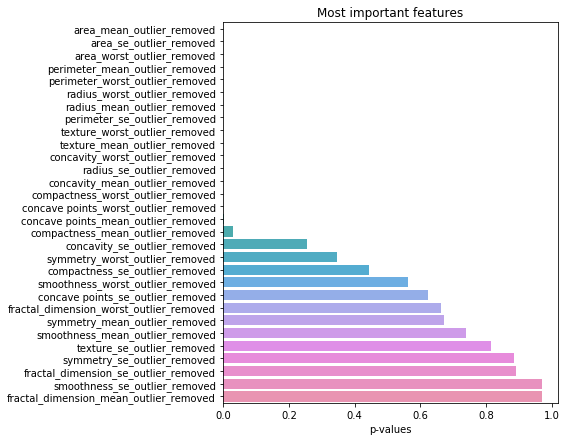

In [30]:
plt.figure(figsize=(6,7))
sns.barplot(x=p_values,y=features)
plt.title('Most important features')
plt.xlabel('p-values')
plt.show()

Based on the last 6 features (with the highest p-values) it is clear that there is very little class seperation

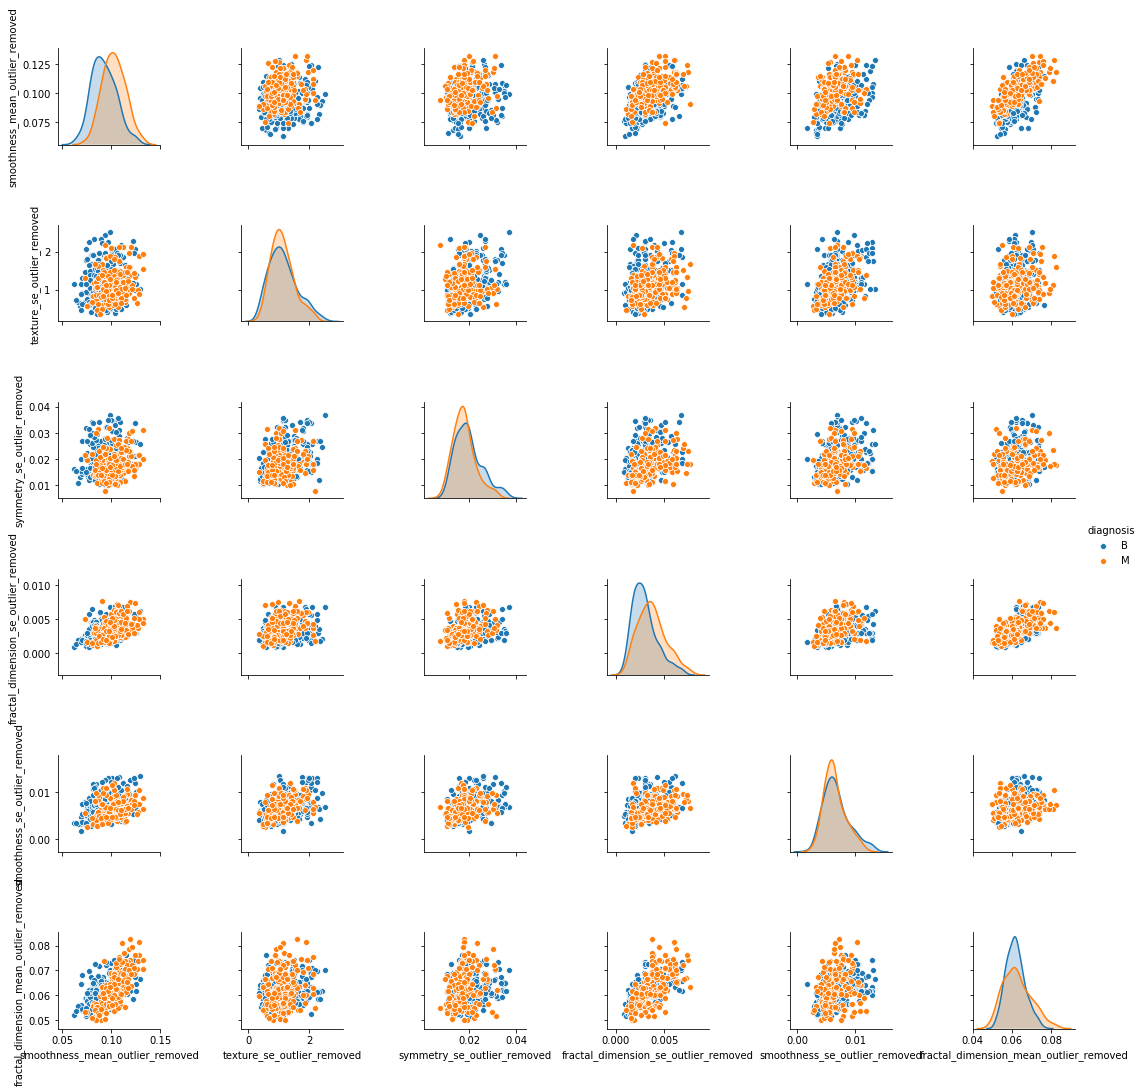

In [31]:
bad_features = features[-6:]
bad_features.extend(['diagnosis'])
sns.pairplot(data=X_train.loc[:,bad_features],hue='diagnosis')
plt.show()

Based on the first 6 features (with the lowest p-values) it is clear that there is more class seperation

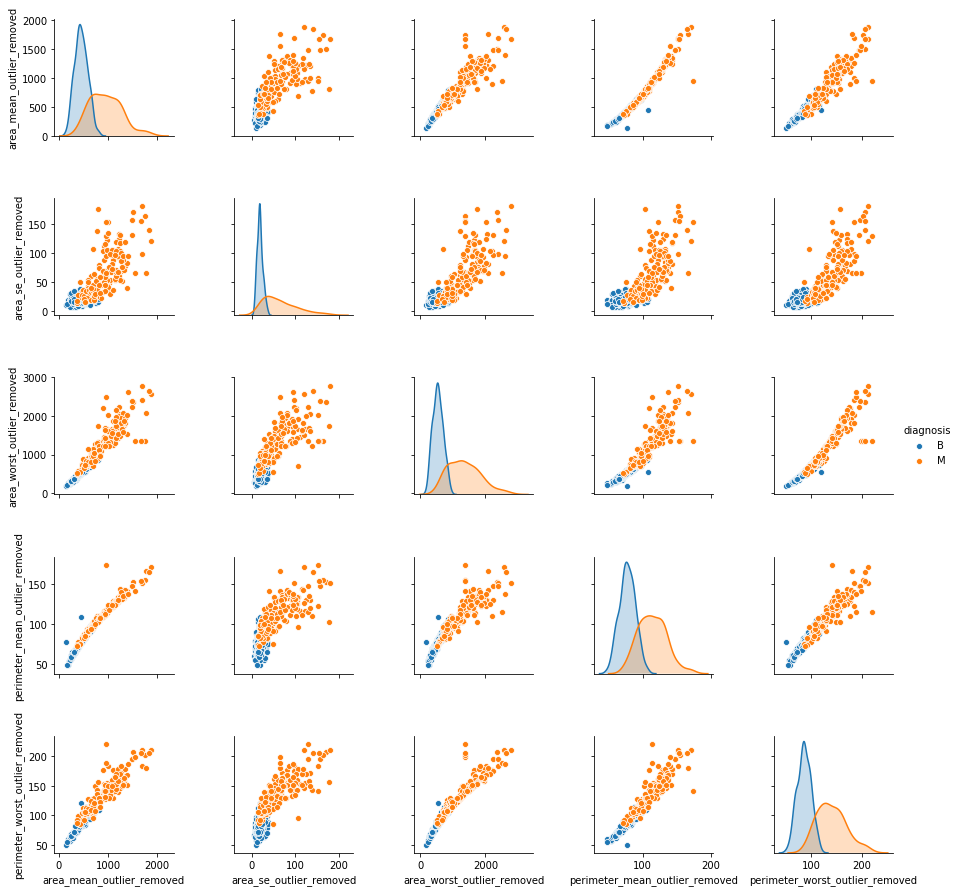

In [32]:
best_features = features[0:5]
best_features.extend(['diagnosis'])
sns.pairplot(data=X_train.loc[:,best_features],hue='diagnosis')
plt.show()

Below a heat map showing the correlation amongst the independent features

In [33]:
correlation_matrix = X_train.loc[:,features[0:15]].corr()

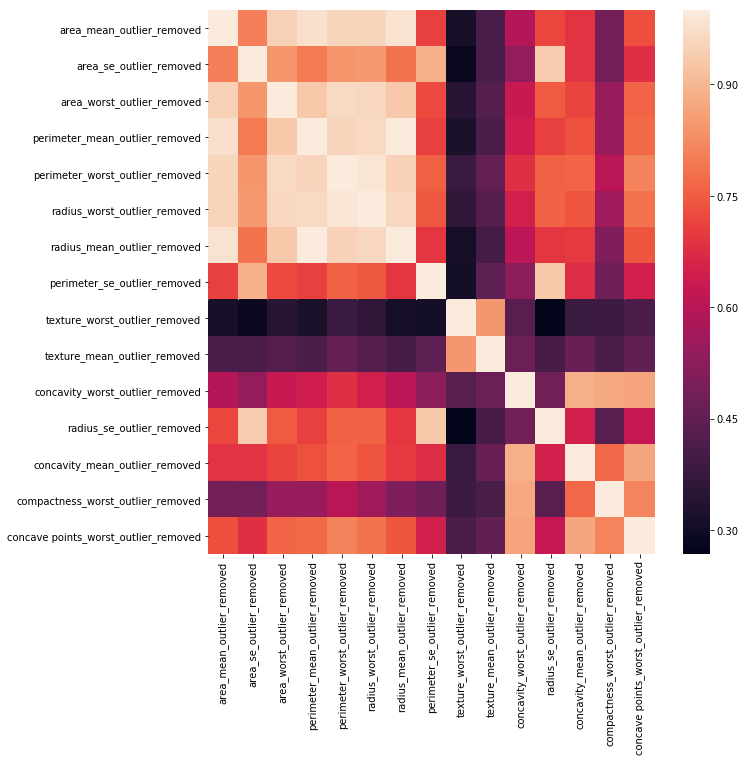

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(data=correlation_matrix)
plt.show()

Some of these features above a very highly correlated and cannot be used together as independent features as it will make the model unstable

In [35]:
correlation_matrix

,area_mean_outlier_removed,area_se_outlier_removed,area_worst_outlier_removed,perimeter_mean_outlier_removed,perimeter_worst_outlier_removed,radius_worst_outlier_removed,radius_mean_outlier_removed,perimeter_se_outlier_removed,texture_worst_outlier_removed,texture_mean_outlier_removed,concavity_worst_outlier_removed,radius_se_outlier_removed,concavity_mean_outlier_removed,compactness_worst_outlier_removed,concave points_worst_outlier_removed
area_mean_outlier_removed,1.000000,0.805551,0.947880,0.979703,0.957438,0.955387,0.981653,0.709248,0.315784,0.413579,0.592741,0.718104,0.687392,0.484989,0.731356
area_se_outlier_removed,0.805551,1.000000,0.841414,0.794735,0.842379,0.846940,0.783860,0.888583,0.287709,0.414029,0.538350,0.938619,0.690248,0.483803,0.681684
area_worst_outlier_removed,0.947880,0.841414,1.000000,0.933835,0.963576,0.960584,0.931989,0.725535,0.347031,0.430084,0.628789,0.748251,0.716604,0.546208,0.760850
perimeter_mean_outlier_removed,0.979703,0.794735,0.933835,1.000000,0.957075,0.963328,0.997640,0.709458,0.321492,0.415600,0.642228,0.706215,0.732387,0.546551,0.770764
perimeter_worst_outlier_removed,0.957438,0.842379,0.963576,0.957075,1.000000,0.986587,0.951331,0.756138,0.380334,0.459357,0.681971,0.757520,0.761498,0.602895,0.811409
radius_worst_outlier_removed,0.955387,0.846940,0.960584,0.963328,0.986587,1.000000,0.962804,0.743386,0.361044,0.433609,0.647679,0.758703,0.738384,0.557449,0.784861
radius_mean_outlier_removed,0.981653,0.783860,0.931989,0.997640,0.951331,0.962804,1.000000,0.691693,0.311655,0.402391,0.606897,0.693053,0.697453,0.504172,0.741974
perimeter_se_outlier_removed,0.709248,0.888583,0.725535,0.709458,0.756138,0.743386,0.691693,1.000000,0.308507,0.447662,0.527373,0.931775,0.675736,0.476831,0.648797
texture_worst_outlier_removed,0.315784,0.287709,0.347031,0.321492,0.380334,0.361044,0.311655,0.308507,1.000000,0.845434,0.439363,0.268625,0.382418,0.385112,0.416972
texture_mean_outlier_removed,0.413579,0.414029,0.430084,0.415600,0.459357,0.433609,0.402391,0.447662,0.845434,1.000000,0.468778,0.406940,0.464025,0.410177,0.453339


# Perform class balancing on the training data

In [36]:
Samples=X_train[X_train['diagnosis']=='M'].sample(n=dict(Counter(X_train['diagnosis'])).get('B') - dict(Counter(X_train['diagnosis'])).get('M'))

In [37]:
X_train = pd.concat(objs=[X_train,Samples],axis=0)

In [38]:
Counter(X_train['diagnosis'])

Counter({'B': 285, 'M': 285})

# Split data into X and Y

In [39]:
Y_train = X_train['diagnosis']
Y_test = X_test['diagnosis']
X_train = X_train.loc[:,features[0:15]]
X_test = X_test.loc[:,features[0:15]]

# Scale the data

In [40]:
Rscaler = RobustScaler()
X_train_transformed = Rscaler.fit_transform(X_train)
X_test_transformed = Rscaler.transform(X_test)

# Convert response variable to binary

In [41]:
Y_train.replace(['M', 'B'], [1, 0], inplace=True)
Y_test.replace(['M', 'B'], [1, 0], inplace=True)

# Feature importances

Apply forward feature selection technique using a scalable model NB that will run fast and provide a good idea of the importance of a feature and how much it contributes to predicting the response variable

In [42]:
forward_feature_selection = dict({})
for feature_index in range(15):
    GNB_model = GaussianNB()
    GNB_model.fit(X=np.reshape(np.array([X_train_transformed[:,feature_index]]),(-1,1)),y=np.reshape(np.array(Y_train),(-1,1)))
    if forward_feature_selection.get(features[0:15][feature_index],0) == 0:
        forward_feature_selection[features[0:15][feature_index]] = GNB_model.score(X=np.reshape(np.array([X_test_transformed[:,feature_index]]),(-1,1)),y=np.reshape(np.array(Y_test),(-1,1)))
    else:
        continue
forward_feature_selection        

{'area_mean_outlier_removed': 0.8859649122807017,
 'area_se_outlier_removed': 0.9035087719298246,
 'area_worst_outlier_removed': 0.9473684210526315,
 'perimeter_mean_outlier_removed': 0.868421052631579,
 'perimeter_worst_outlier_removed': 0.9385964912280702,
 'radius_worst_outlier_removed': 0.9473684210526315,
 'radius_mean_outlier_removed': 0.8596491228070176,
 'perimeter_se_outlier_removed': 0.8333333333333334,
 'texture_worst_outlier_removed': 0.7719298245614035,
 'texture_mean_outlier_removed': 0.7719298245614035,
 'concavity_worst_outlier_removed': 0.8596491228070176,
 'radius_se_outlier_removed': 0.8771929824561403,
 'concavity_mean_outlier_removed': 0.9035087719298246,
 'compactness_worst_outlier_removed': 0.7807017543859649,
 'concave points_worst_outlier_removed': 0.8947368421052632}

In [43]:
correlation_matrix.loc[:,'area_mean_outlier_removed']

area_mean_outlier_removed               1.000000
area_se_outlier_removed                 0.805551
area_worst_outlier_removed              0.947880
perimeter_mean_outlier_removed          0.979703
perimeter_worst_outlier_removed         0.957438
radius_worst_outlier_removed            0.955387
radius_mean_outlier_removed             0.981653
perimeter_se_outlier_removed            0.709248
texture_worst_outlier_removed           0.315784
texture_mean_outlier_removed            0.413579
concavity_worst_outlier_removed         0.592741
radius_se_outlier_removed               0.718104
concavity_mean_outlier_removed          0.687392
compactness_worst_outlier_removed       0.484989
concave points_worst_outlier_removed    0.731356
Name: area_mean_outlier_removed, dtype: float64

Since most of the features are very highly correlated I pick the below 4 features for the final models

In [44]:
best_features = ['area_mean_outlier_removed','texture_worst_outlier_removed',
                 'texture_mean_outlier_removed','compactness_worst_outlier_removed']

In [45]:
X_train_transformed = X_train_transformed[:,[0,8,9,13]]
X_test_transformed = X_test_transformed[:,[0,8,9,13]]

# Training different models

## Random model

In [46]:
random_model_y_train_prob = np.random.rand(X_train_transformed.shape[0],2)
random_model_y_train_pred = np.argmax(a=random_model_y_train_prob,axis=1)

In [47]:
random_model_y_test_prob = np.random.rand(X_test_transformed.shape[0],2)
random_model_y_test_pred = np.argmax(a=random_model_y_test_prob,axis=1)

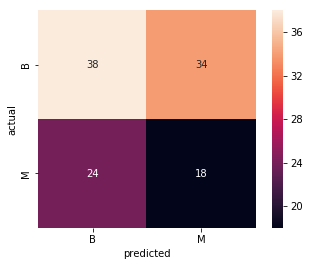

In [48]:
sns.heatmap(confusion_matrix(Y_test, random_model_y_test_pred),annot=True,
            fmt='d',square=True,xticklabels=['B','M'],yticklabels=['B','M'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

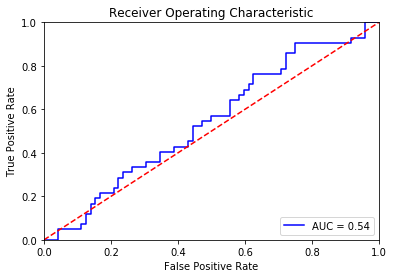

In [49]:
preds = random_model_y_test_prob[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
print(classification_report(Y_test, random_model_y_test_pred))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57        72
           1       0.35      0.43      0.38        42

    accuracy                           0.49       114
   macro avg       0.48      0.48      0.48       114
weighted avg       0.51      0.49      0.50       114



In [51]:
print(classification_report(Y_train, random_model_y_train_pred))

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       285
           1       0.48      0.49      0.49       285

    accuracy                           0.48       570
   macro avg       0.48      0.48      0.48       570
weighted avg       0.48      0.48      0.48       570



## Logistic Regression model

In [52]:
params={'base_estimator__penalty':['l1','l2'],'base_estimator__C':[0.001,0.01,0.1,1,10,20,30,100,1000]}
logistic_model = LogisticRegression()
cal_logistic_model = CalibratedClassifierCV(base_estimator=logistic_model)

In [53]:
grid = GridSearchCV(estimator=cal_logistic_model,param_grid=params,scoring='f1',cv=3,n_jobs=-1)

In [54]:
cal_logistic_model = grid.fit(X=X_train_transformed,y=np.reshape(np.array(Y_train),(-1,1)))

In [55]:
cal_logistic_model.best_params_

{'base_estimator__C': 10, 'base_estimator__penalty': 'l2'}

In [56]:
predicted_prob=cal_logistic_model.predict_proba(X=X_test_transformed)
predicted_label=cal_logistic_model.predict(X=X_test_transformed)

In [57]:
cal_logistic_model.classes_

array([0, 1], dtype=int64)

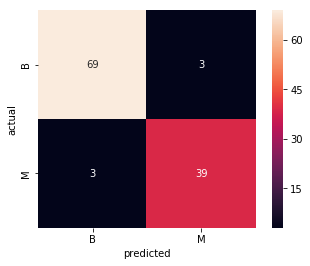

In [58]:
sns.heatmap(confusion_matrix(Y_test, predicted_label),annot=True,
            fmt='d',square=True,xticklabels=['B','M'],yticklabels=['B','M'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

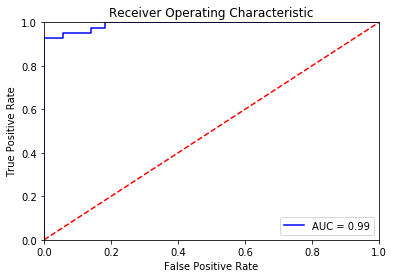

In [59]:
preds = predicted_prob[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
print(classification_report(Y_test, predicted_label))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [61]:
print(classification_report(Y_train, cal_logistic_model.predict(X=X_train_transformed)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       285
           1       0.95      0.94      0.95       285

    accuracy                           0.95       570
   macro avg       0.95      0.95      0.95       570
weighted avg       0.95      0.95      0.95       570



## Random Forest model

In [62]:
params={'base_estimator__n_estimators':[5,10,20,50,100,1000],'base_estimator__max_depth':[3,5,7]}
rf_model = RandomForestClassifier()
cal_rf_model = CalibratedClassifierCV(base_estimator=rf_model)

In [63]:
grid = GridSearchCV(estimator=cal_rf_model,param_grid=params,scoring='f1',cv=3,n_jobs=-1)

In [64]:
cal_rf_model = grid.fit(X=X_train_transformed,y=np.reshape(np.array(Y_train),(-1,1)))

In [65]:
cal_rf_model.best_params_

{'base_estimator__max_depth': 7, 'base_estimator__n_estimators': 20}

In [66]:
predicted_prob=cal_rf_model.predict_proba(X=X_test_transformed)
predicted_label=cal_rf_model.predict(X=X_test_transformed)

In [67]:
cal_rf_model.classes_

array([0, 1], dtype=int64)

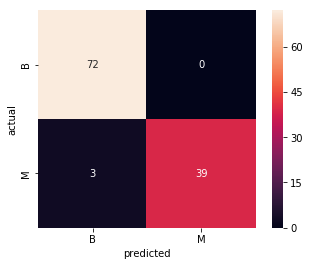

In [68]:
sns.heatmap(confusion_matrix(Y_test, predicted_label),annot=True,
            fmt='d',square=True,xticklabels=['B','M'],yticklabels=['B','M'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

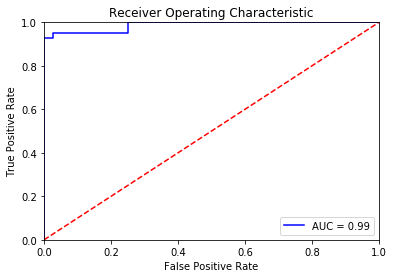

In [69]:
preds = predicted_prob[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [70]:
print(classification_report(Y_test, predicted_label))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [71]:
print(classification_report(Y_train, cal_rf_model.predict(X=X_train_transformed)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       285

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570



## Multilayer perceptron (MLP)

In [72]:
# Initialize the neural network

## parameters of the NN
dropoutrate = 0.5
batchsize = 30
inputdim = X_train_transformed.shape[1]  # of input features
opt = adam(lr=0.001) # Adam optimizer

model = Sequential()
model.add(Dense(10, input_dim=inputdim, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(40, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(40, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer=opt,metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 40)                440       
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_____________________________________

In [73]:
history = model.fit(X_train_transformed, np.reshape(np.array(Y_train),(-1,1)), epochs=50, validation_split=0.2, batch_size=batchsize, verbose=0)

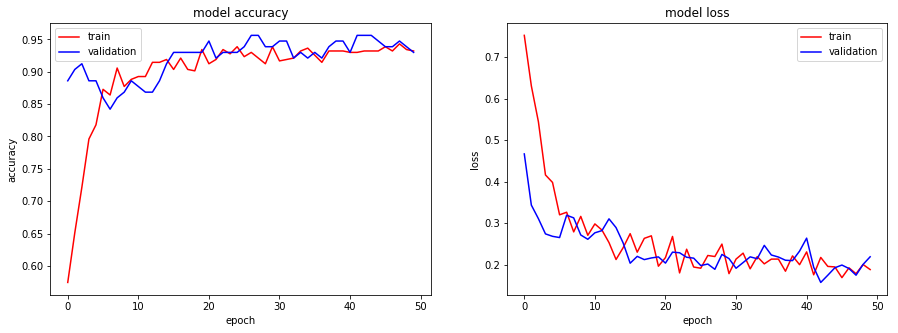

In [74]:
# Plot history
plt.figure(figsize=(15,5))
plt.subplot(121)
# Accuray 
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

# plt.show()
plt.subplot(122)
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [75]:
model.evaluate(X_test_transformed,np.reshape(np.array(Y_test),(-1,1)))

114/114 [==============================] - 0s 44us/step


[0.14563259600024475, 0.9473684210526315]

In [76]:
predicted_prob_pos_class_M=model.predict(X_test_transformed) # returns predicted prob for the positive class (M)
predicted_prob_pos_class_M=predicted_prob_pos_class_M.squeeze(axis=1)
predicted_prob_neg_class_B=1-predicted_prob_pos_class_M
predicted_prob = np.array(pd.DataFrame(list(zip(predicted_prob_neg_class_B,predicted_prob_pos_class_M))),dtype='float64')
predicted_label = np.argmax(a=predicted_prob,axis=1)

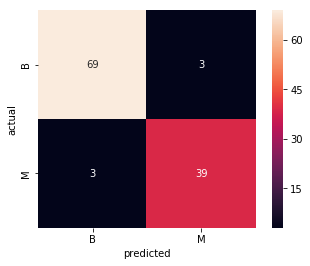

In [77]:
sns.heatmap(confusion_matrix(Y_test, predicted_label),annot=True,
            fmt='d',square=True,xticklabels=['B','M'],yticklabels=['B','M'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

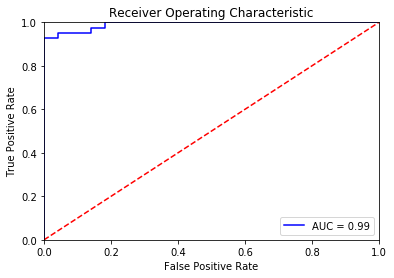

In [78]:
preds = predicted_prob[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

# plot

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [79]:
print(classification_report(Y_test, predicted_label))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [80]:
predicted_prob_pos_class_M=model.predict(X_train_transformed) # returns predicted prob for the positive class (M)
predicted_prob_pos_class_M=predicted_prob_pos_class_M.squeeze(axis=1)
predicted_prob_neg_class_B=1-predicted_prob_pos_class_M
predicted_prob = np.array(pd.DataFrame(list(zip(predicted_prob_neg_class_B,predicted_prob_pos_class_M))),dtype='float64')
predicted_label = np.argmax(a=predicted_prob,axis=1)

In [81]:
print(classification_report(Y_train, predicted_label))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       285
           1       0.97      0.93      0.95       285

    accuracy                           0.95       570
   macro avg       0.95      0.95      0.95       570
weighted avg       0.95      0.95      0.95       570

